In [1]:
from math import sqrt
from pmdarima.arima import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import warnings

In [2]:
warnings.filterwarnings("ignore")

# imports

# loading Dataset

In [3]:
INPUT_PATH = '/Users/maedeh/Desktop/demand_project/shoofer-demand-prediction/data/labels.parquet'
OUTPUT_PATH = '/Users/maedeh/Desktop/demand_project/shoofer-demand-prediction/data/arima_predict.parquet'

In [4]:
def load_data(path):
    dataset = pd.read_parquet(path, engine = 'pyarrow') 
    return dataset

In [5]:
rides_df = load_data(INPUT_PATH)
rides_df.head()

,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


# aggregating_labels 

In [6]:
def aggregating_labels(rides_df):
    loc_ts={}
    demand=[]
    pre_Location=1
    
    for i in range(len(rides_df)):
        
      if rides_df.Location[i]!=pre_Location:
        loc_ts[f'LocationID_{pre_Location}']=demand
        demand=[]
          
      demand.append(rides_df.Demand[i])
      pre_Location = rides_df.Location[i]
        
    loc_ts[f'LocationID_{pre_Location}'] = demand
    location_labels_df = pd.DataFrame(loc_ts)
    
    return location_labels_df

In [7]:
location_labels_df = aggregating_labels(rides_df)
print(f'location_labels_df shape : {location_labels_df.shape}')
location_labels_df.head()

location_labels_df shape : (120, 262)


,LocationID_1,LocationID_2,LocationID_3,LocationID_4,LocationID_5,LocationID_6,LocationID_7,LocationID_8,LocationID_9,LocationID_10,...,LocationID_256,LocationID_257,LocationID_258,LocationID_259,LocationID_260,LocationID_261,LocationID_262,LocationID_263,LocationID_264,LocationID_265
0,40.0,0.0,0.0,174.0,3.0,1.0,126.0,1.0,0.0,47.0,...,125.0,5.0,5.0,1.0,48.0,510.0,837.0,1942.0,1176.0,124.0
1,31.0,0.0,2.0,32.0,2.0,3.0,39.0,0.0,2.0,36.0,...,13.0,2.0,4.0,1.0,15.0,432.0,758.0,1328.0,1110.0,59.0
2,27.0,0.0,2.0,51.0,2.0,1.0,48.0,0.0,1.0,53.0,...,17.0,2.0,5.0,0.0,14.0,338.0,1344.0,1746.0,1249.0,54.0
3,7.0,0.0,1.0,43.0,2.0,1.0,38.0,0.0,1.0,46.0,...,17.0,2.0,4.0,5.0,22.0,432.0,1479.0,1967.0,1294.0,51.0
4,15.0,0.0,2.0,42.0,2.0,5.0,49.0,1.0,3.0,43.0,...,12.0,2.0,3.0,4.0,20.0,436.0,1552.0,2035.0,1393.0,45.0


# ARIMA MODEL

## train 

In [8]:
train_size_ratio = 0.12

In [9]:
def split_data(location_labels_df, location, train_size_ratio):
    size = int(len(location_labels_df) * train_size_ratio)
    train_data = location_labels_df.loc[0:size, location]
    test_data = location_labels_df.loc[size:, location]
    return (train_data, test_data)

In [10]:
def arima_forecast(train_data, test_data):
    history = [x for x in train_data]
    predictions = []
    model = pm.arima.auto_arima(
                              history, start_p=1, start_q=1,
                              test='kpss', max_p=8, max_q=8,
                              seasonal=False, m=1,
                              d=None, start_P=0,
                              suppress_warnings=False, trace=False)
    for t in range(len(test_data)):
        best_arima_model_fit = pm.arima.ARIMA(order=model.get_params().get("order")).fit(history)
        output = best_arima_model_fit.predict(n_periods=1)
        yhat = output[0]
        predictions.append(int(yhat))
        obs = test_data.iloc[t]
        history.append(obs)
    
    test_data = test_data.reset_index()
    return (test_data.iloc[:,1], predictions, best_arima_model_fit.fittedvalues())


### train and predict for all locationIDs


In [11]:
def rmse(test_data, predictions):
  rmse = sqrt(mean_squared_error(test_data, predictions))
  return rmse

In [12]:
def mape(test_data, predictions):
  mape = mean_absolute_percentage_error(test_data, predictions)
  return mape

In [13]:
def predict_all_location(location_labels_df, train_size_ratio):

    all_loc_rmse = []
    all_loc_mape = []
    predicted_data_all_loc = {}
    test_data_all_loc = {}
    fitted_data_all_loc = {}
    column = location_labels_df.columns
    
    for loc in column:
        
        train_data, test_data = split_data (location_labels_df, loc, train_size_ratio)
        result = arima_forecast(train_data, test_data)
                
        test_data_all_loc[loc] = result[0]
        predicted_data_all_loc[loc] = result[1]
        fitted_data_all_loc[loc] = result[2]
        
        val_rmse = rmse (result[0], result[1])
        val_mape = mape (result[0], result[1])
        all_loc_rmse.append(val_rmse)
        all_loc_mape.append(val_mape)
    
    all_loc_rmse = pd.DataFrame(all_loc_rmse, index=column , columns= ['rmse'])
    all_loc_mape = pd.DataFrame(all_loc_mape, index=column , columns= ['mape'])
    all_loc_rmse = pd.DataFrame(all_loc_rmse)
    all_loc_mape = pd.DataFrame(all_loc_mape)
    test_data_all_loc = pd.DataFrame(test_data_all_loc)
    fitted_data_all_loc = pd.DataFrame(fitted_data_all_loc)
    predicted_data_all_loc = pd.DataFrame(predicted_data_all_loc)
    return (test_data_all_loc, predicted_data_all_loc, fitted_data_all_loc, all_loc_rmse, all_loc_mape)

In [14]:
test_data_all_loc, predicted_data_all_loc, fitted_data_all_loc, all_loc_rmse, all_loc_mape = predict_all_location(location_labels_df, train_size_ratio)

In [15]:
print(f'predicted_data_all_loc shape : {predicted_data_all_loc.shape}')
predicted_data_all_loc.head()

predicted_data_all_loc shape : (106, 262)


,LocationID_1,LocationID_2,LocationID_3,LocationID_4,LocationID_5,LocationID_6,LocationID_7,LocationID_8,LocationID_9,LocationID_10,...,LocationID_256,LocationID_257,LocationID_258,LocationID_259,LocationID_260,LocationID_261,LocationID_262,LocationID_263,LocationID_264,LocationID_265
0,18,0,1,86,1,2,49,0,1,47,...,31,3,0,2,21,427,1162,1871,1294,56
1,18,0,1,162,1,2,49,0,0,48,...,32,2,1,2,21,431,1282,2136,1327,56
2,19,0,1,35,1,2,48,0,1,48,...,31,2,1,2,21,421,1217,1679,1255,56
3,17,0,1,109,1,2,48,0,0,49,...,30,1,1,2,20,416,1626,2092,1314,56
4,12,0,1,108,1,2,49,0,1,48,...,29,1,2,2,21,420,1454,2141,1257,55


## evaluation

### plots

In [70]:
def plot_high_demand_error(all_loc_rmse,all_loc_mape):
    plt.rcParams['figure.figsize'] = (50, 30)
    index_high_demand = location_labels_df.sum().sort_values(ascending=False).index[:51]
    
    plt.subplot(2,1,1)
    plt.plot(all_loc_rmse.loc[index_high_demand], linewidth=6)
    plt.title('RMSE of High Demand LocationID', fontsize=45)
    plt.ylabel('rmse', fontsize=35)
    plt.xlabel('LocationID', fontsize=35)
    plt.xticks(range(1,52), list(index_high_demand), rotation=45)
    plt.tick_params(axis='both', labelsize=25)
    
    
    plt.subplot(2,1,2)
    plt.plot(all_loc_mape.loc[index_high_demand], color='orange', linewidth=6)
    plt.title('MAPE of High Demand LocationID', fontsize=45)
    plt.ylabel('mape', fontsize=35)
    plt.xlabel('LocationID', fontsize=35)
    plt.xticks(range(1,52), list(index_high_demand), rotation=45)
    plt.tick_params(axis='both', labelsize=25)
    plt.tight_layout()
    
    plt.show()

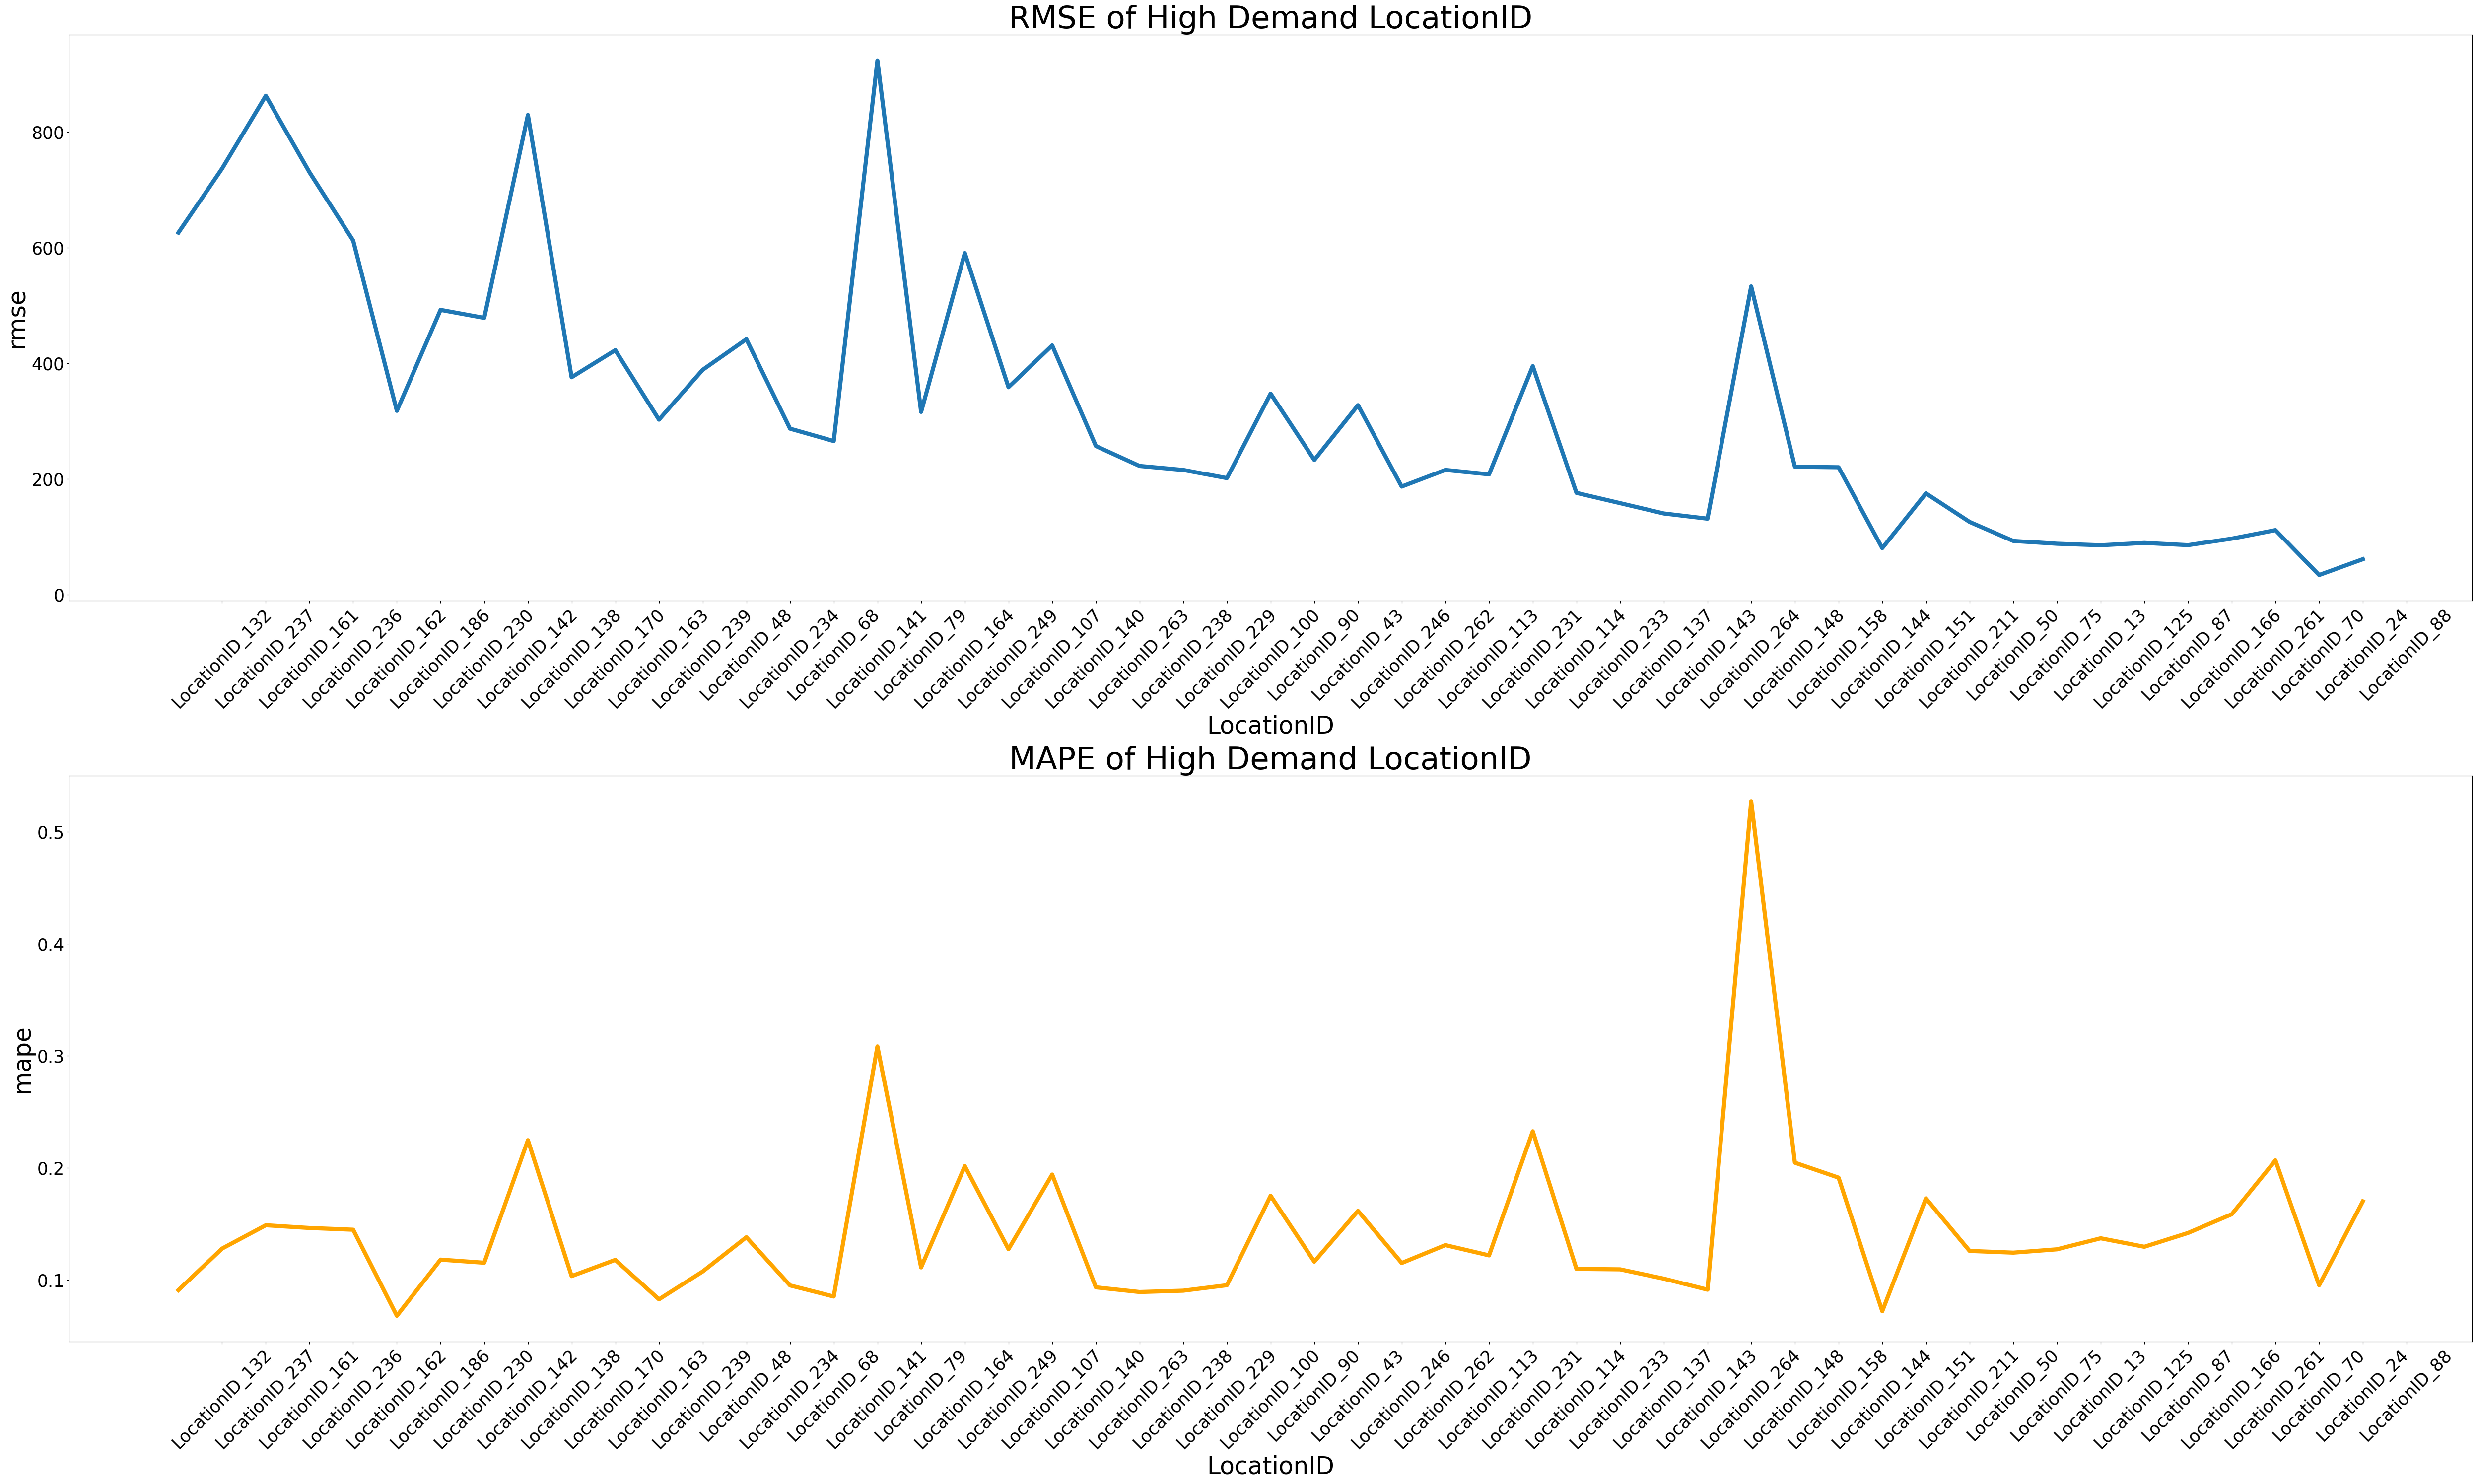

In [71]:
plot_high_demand_error(all_loc_rmse, all_loc_mape)

In [17]:
def evaluation(test_data_all_loc, predicted_data_all_loc):
    index_high_demand = location_labels_df.sum().sort_values(ascending=False).index[:51]
    predicted_data_vec = predicted_data_all_loc[index_high_demand].to_numpy().reshape((1,-1))
    test_data_vec = test_data_all_loc[index_high_demand].to_numpy().reshape((1,-1))
    mape_error = mape(test_data_vec,predicted_data_vec)
    rmse_error = rmse(test_data_vec,predicted_data_vec)
    print(f'mape of high demand locations: {mape_error}')
    print(f'rmse of high demand locations: {rmse_error}')

In [18]:
evaluation(test_data_all_loc, predicted_data_all_loc)

mape of high demand locations: 0.14272925289867838
rmse of high demand locations: 389.3521141748567


# Save file

In [19]:
def save_val_predicted(dataset, path):
    labels_df = dataset.to_parquet(path, index=False)

In [20]:
save_val_predicted(predicted_data_all_loc, OUTPUT_PATH)